# Tuning Gradient Boosting Classifier

In this problem we'll examine the wine quality dataset hosted on the UCI website. This data records 11 chemical properties (such as the concentrations of sugar, citric acid, alcohol, pH etc.) of thousands of red and white wines from northern Portugal, as well as the quality of the wines, recorded on a scale from 1 to 10. In this problem, we will only look at the data for red wine.

We will use gradient boosting classifier to predict wine quality.

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics, preprocessing
from sklearn import cross_validation
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [213]:
df = pd.read_csv('wine.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


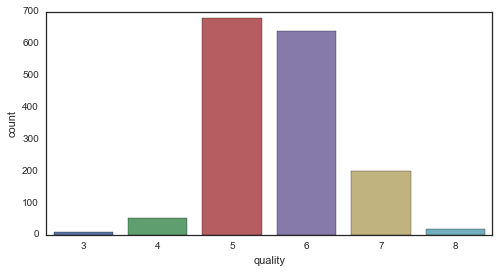

In [214]:
sns.set(style='white', context='notebook')
plt.figure(figsize=(8, 4))
sns.countplot(x='quality',data=df)

Transform multi-class problem to binary class problem. Let wine is 'good' if its quality is greater than 6.

In [215]:
df['quality'] = df.quality.apply(lambda x: 1 if x >= 7 else 0)
df.quality.value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [216]:
X = df[[col for col in df.columns if 'quality' != col]]
y = df.quality

X.shape, y.shape

((1599, 11), (1599,))

Because this problem is imbalanced, we'll use custom scorer for class selection. Let's classify item to class 1, if its probability is more than some `cutoff` value (we use `cutoff` = 0.3).

Also we will use f1-score as metrics. Using 'accuracy' as metrics seems not to be so good idea because of class imbalance.

In [217]:
def custom_scorer(cutoff):
    def score(clf, X, y):        
        y_pred_proba = clf.predict_proba(X)[:,1]
        y_pred = [1 if y > cutoff else 0 for y in y_pred_proba]
        return metrics.f1_score(y, y_pred)
    return score

In [218]:
def modelfit(clf, X, y, performCV=True, printFeatureImportance=True, cv_folds=5, cutoff=0.3):
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_prob = clf.predict_proba(X)[:,1]
    
    if performCV:
        cv_score = cross_validation.cross_val_score(clf, X, y, cv=cv_folds, scoring=custom_scorer(cutoff))        
        print('CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g | cutoff = %.2f'
            % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score), cutoff))

Use Random Forest Classifier without any tuning as simple benchmark.

In [219]:
X_scaled = preprocessing.scale(X)

In [220]:
modelfit(RandomForestClassifier(random_state=42), X, y)
modelfit(RandomForestClassifier(random_state=42), X_scaled, y)

CV Score : Mean - 0.4604901 | Std - 0.08252234 | Min - 0.3448276 | Max - 0.5882353 | cutoff = 0.30
CV Score : Mean - 0.4672629 | Std - 0.07474165 | Min - 0.3728814 | Max - 0.5882353 | cutoff = 0.30


In [221]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.8, max_depth=3, max_features='sqrt',
                                random_state=42)
modelfit(clf, X_scaled, y)

CV Score : Mean - 0.4585658 | Std - 0.07945892 | Min - 0.3214286 | Max - 0.5555556 | cutoff = 0.30


## Tuning parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

* **min_samples_split** = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
* **min_samples_leaf** = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
* **max_depth = 8** : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
* **max_features = ‘sqrt’** : Its a general thumb-rule to start with square root.
* **subsample = 0.8** : This is a commonly used used start value

![Picture](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/tree-infographic.png)

Source: [link](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [222]:
min_samples_split = round(0.005 * X.shape[0])
min_samples_leaf = 10
max_depth = 5
max_features = 'sqrt'
subsample = 0.8

In [223]:
from sklearn.grid_search import GridSearchCV
parameters = {'n_estimators':np.arange(10, 110, 10)}
clf = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, min_samples_split=min_samples_split, max_depth=max_depth,
                                             min_samples_leaf=min_samples_leaf, max_features=max_features, subsample=subsample,
                                             random_state=42),
                   parameters, cv=5, scoring=custom_scorer(0.3))
clf.fit(X_scaled, y)
print(clf.grid_scores_)

[mean: 0.44982, std: 0.07477, params: {'n_estimators': 10}, mean: 0.48489, std: 0.09886, params: {'n_estimators': 20}, mean: 0.49623, std: 0.07387, params: {'n_estimators': 30}, mean: 0.52116, std: 0.08825, params: {'n_estimators': 40}, mean: 0.51902, std: 0.08519, params: {'n_estimators': 50}, mean: 0.50230, std: 0.08632, params: {'n_estimators': 60}, mean: 0.50350, std: 0.09534, params: {'n_estimators': 70}, mean: 0.49826, std: 0.08907, params: {'n_estimators': 80}, mean: 0.50608, std: 0.09195, params: {'n_estimators': 90}, mean: 0.51006, std: 0.08728, params: {'n_estimators': 100}]


In [224]:
bp, bs = clf.best_params_, clf.best_score_
bp, bs

({'n_estimators': 40}, 0.52116206403932253)

In [225]:
param_test2 = {'max_depth':np.arange(3, 16, 2), 'min_samples_split':np.arange(5, 100, 10)}
clf = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=40,
                                             min_samples_leaf=min_samples_leaf, max_features=max_features, subsample=subsample,
                                             random_state=42),
                   param_test2, cv=5, scoring=custom_scorer(0.3))
clf.fit(X_scaled, y)
bp, bs = clf.best_params_, clf.best_score_
bp, bs

({'max_depth': 5, 'min_samples_split': 5}, 0.52116206403932253)

In [226]:
param_test4 = {'max_features':np.arange(2,12)}
clf = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                             min_samples_leaf=min_samples_leaf, subsample=subsample,
                                             random_state=42),
                   param_test4, cv=5, scoring=custom_scorer(0.3))
clf.fit(X_scaled, y)
bp, bs = clf.best_params_, clf.best_score_
bp, bs

({'max_features': 3}, 0.52116206403932253)

In [227]:
modelfit(GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=min_samples_leaf, max_features=3, subsample=subsample,
                                   random_state=42), X_scaled, y)

CV Score : Mean - 0.521323 | Std - 0.08825065 | Min - 0.3859649 | Max - 0.6588235 | cutoff = 0.30


In [228]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
clf = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                             min_samples_leaf=min_samples_leaf, max_features=3,
                                             random_state=42),
                   param_test5, cv=5, scoring=custom_scorer(0.3))
clf.fit(X_scaled, y)
bp, bs = clf.best_params_, clf.best_score_
bp, bs

({'subsample': 0.8}, 0.52116206403932253)

In [229]:
param_test6 = {'min_samples_leaf':np.arange(10, 101, 10)}
clf = GridSearchCV(GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                             max_features=3, subsample=0.8, random_state=42),
                   param_test6, cv=5, scoring=custom_scorer(0.3))
clf.fit(X_scaled, y)
bp, bs = clf.best_params_, clf.best_score_
bp, bs

({'min_samples_leaf': 10}, 0.52116206403932253)

In [230]:
lr = 0.1 / 2
ne = 40 * 2
modelfit(GradientBoostingClassifier(learning_rate=lr, n_estimators=ne, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=10, max_features=3, subsample=0.8,
                                   random_state=42), X_scaled, y)

CV Score : Mean - 0.5030049 | Std - 0.06990824 | Min - 0.3793103 | Max - 0.5952381 | cutoff = 0.30


In [231]:
lr = 0.1 / 10
ne = 40 * 10
modelfit(GradientBoostingClassifier(learning_rate=lr, n_estimators=ne, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=10, max_features=3, subsample=0.8,
                                   random_state=42), X_scaled, y)

CV Score : Mean - 0.4955755 | Std - 0.0819878 | Min - 0.3508772 | Max - 0.6046512 | cutoff = 0.30


In [232]:
lr = 0.1 / 15
ne = 40 * 15
modelfit(GradientBoostingClassifier(learning_rate=lr, n_estimators=ne, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=10, max_features=3, subsample=0.8,
                                   random_state=42), X_scaled, y)

CV Score : Mean - 0.4885044 | Std - 0.08985706 | Min - 0.3508772 | Max - 0.627907 | cutoff = 0.30


In [239]:
best_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=10, max_features=3, subsample=0.8, random_state=42)
for cutoff in np.arange(0.1, 0.51, 0.05):
    modelfit(best_clf, X_scaled, y, cutoff=cutoff)

CV Score : Mean - 0.4836459 | Std - 0.04577267 | Min - 0.4228571 | Max - 0.5517241 | cutoff = 0.10
CV Score : Mean - 0.4956259 | Std - 0.04254329 | Min - 0.4516129 | Max - 0.5688073 | cutoff = 0.15
CV Score : Mean - 0.5191068 | Std - 0.04742442 | Min - 0.46875 | Max - 0.6041667 | cutoff = 0.20
CV Score : Mean - 0.5267007 | Std - 0.07103371 | Min - 0.4333333 | Max - 0.6516854 | cutoff = 0.25
CV Score : Mean - 0.521323 | Std - 0.08825065 | Min - 0.3859649 | Max - 0.6588235 | cutoff = 0.30
CV Score : Mean - 0.4881117 | Std - 0.08438883 | Min - 0.3571429 | Max - 0.6075949 | cutoff = 0.35
CV Score : Mean - 0.4597362 | Std - 0.08475609 | Min - 0.3571429 | Max - 0.5915493 | cutoff = 0.40
CV Score : Mean - 0.4304454 | Std - 0.09012337 | Min - 0.2962963 | Max - 0.5416667 | cutoff = 0.45
CV Score : Mean - 0.395945 | Std - 0.07925395 | Min - 0.2962963 | Max - 0.5274725 | cutoff = 0.50


In [240]:
# Best result
best_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=10, max_features=3, subsample=0.8, random_state=42)
modelfit(best_clf, X_scaled, y, cutoff=0.25)

CV Score : Mean - 0.5267007 | Std - 0.07103371 | Min - 0.4333333 | Max - 0.6516854 | cutoff = 0.25


In [247]:
y_pred = [1 if y > 0.25 else 0 for y in best_clf.predict_proba(X_scaled)[:,1]]
metrics.accuracy_score(y, y_pred)

0.92895323014131659

In [235]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=10, max_features=3, subsample=0.8,
                                   random_state=42)
clf.fit(X_scaled, y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=5, max_features=3, max_leaf_nodes=None,
              min_samples_leaf=10, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)

Select two features with highest importance just to visualize decision surface. CV score for the model with only two features selected is quite low.

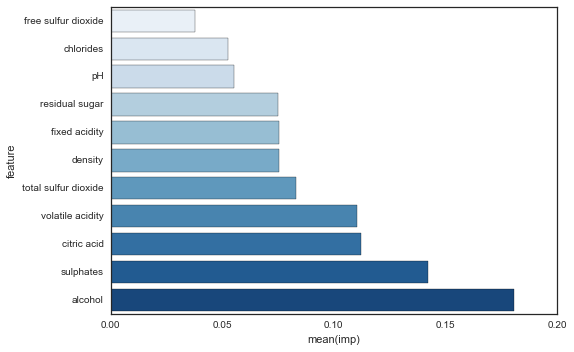

In [236]:
clf.feature_importances_
feat_imp = pd.DataFrame()
feat_imp['feature'] = X.columns
feat_imp['imp'] = clf.feature_importances_
sns.barplot(x='imp', y='feature', data=feat_imp.sort_values('imp'), orient='h', palette='Blues')

CV Score : Mean - 0.4528759 | Std - 0.04770204 | Min - 0.4 | Max - 0.5411765 | cutoff = 0.25


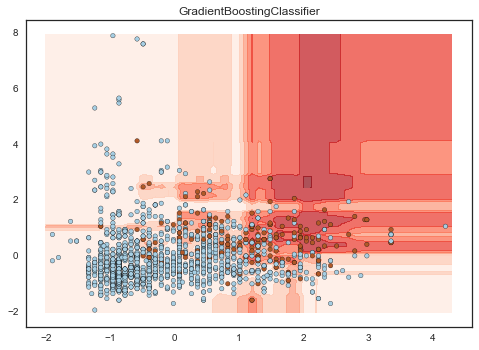

In [237]:
def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds, alpha=0.7)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    #plt.show()
    
X_imp = preprocessing.scale(X[['alcohol', 'sulphates']])

clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=5, min_samples_split=5,
                                   min_samples_leaf=10, max_features=2, subsample=0.8,
                                   random_state=42)
plt.title('GradientBoostingClassifier')
plot_decision_surface(clf, X_imp, y)
modelfit(clf, X_imp, y, cutoff=0.25)